In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import scipy

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels, activation=nn.ReLU()):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=1),
            activation,
            nn.Conv1d(mid_channels, out_channels, kernel_size=1),
        )

    def forward(self, x):
        return self.conv(x)

class FFTBlock(nn.Module):
    def __init__(self, in_channels, out_channels, modes, activation=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        weights = torch.rand(in_channels, out_channels, modes).cfloat() 
        scale = 1 / in_channels / out_channels
        self.weights = nn.Parameter(weights * scale)
        self.conv = ConvBlock(out_channels, out_channels, out_channels, activation=nn.GELU())
        self.skip = nn.Conv1d(out_channels, out_channels, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.shape[-1]//2 + 1).cfloat().to(x.device)
        out_ft[:, :, :self.modes] = torch.einsum("bix,iox->box", x_ft[:, :, :self.modes], self.weights)
        x1 = torch.fft.irfft(out_ft, n=x.shape[-1])
        x1 = self.conv(x1)
        x2 = self.skip(x)
        return (x1 + x2) if self.activation is None else self.activation(x1 + x2)

class FNO1d(nn.Module):
    def __init__(self, modes, width, activation=nn.ReLU()):
        super().__init__()
        self.padding = 8 # pad the domain if input is non-periodic

        self.p_layer = nn.Linear(2, width)
        self.fft_block0 = FFTBlock(width, width, modes, activation=activation)
        self.fft_block1 = FFTBlock(width, width, modes, activation=activation)
        self.fft_block2 = FFTBlock(width, width, modes, activation=activation)
        self.fft_block3 = FFTBlock(width, width, modes, activation=None)
        self.q_layer = ConvBlock(width, 1, width*2, activation=nn.ReLU())

    def forward(self, x):
        grid = torch.linspace(0, 1, x.shape[1]).repeat([x.shape[0], 1]).unsqueeze(-1).to(x.device)
        x = torch.cat((x, grid), dim=-1)        # (batch_size, n_points, 2)
        x = self.p_layer(x).permute(0, 2, 1)    # (batch_sdize, width, n_points)
        # x = F.pad(x, [0, self.padding])       # pad the domain if input is non-periodic

        x = self.fft_block0(x)
        x = self.fft_block1(x)
        x = self.fft_block2(x)
        x = self.fft_block3(x)

        # x = x[..., :-self.padding]            # pad the domain if input is non-periodic
        x = self.q_layer(x).permute(0, 2, 1)
        return x

In [5]:
from torch.utils.data import DataLoader, TensorDataset

## Data
n_train = 1000
n_test = 100

sub_sampling = 2**3          # subsampling rate
batch_size = 64
mesh_size = 1024

data = scipy.io.loadmat("data/burgers_data_R10.mat")
x_data_np = data["a"]   # a(x): initial condition
y_data_np = data["u"]   # u(x): PDE solution

In [10]:
x_data = torch.tensor(x_data_np).float()[:, ::sub_sampling]
y_data = torch.tensor(y_data_np).float()[:, ::sub_sampling]

x_train = x_data[:n_train]
c_train = torch.linspace(-1, 1, mesh_size).repeat([n_train, 1])
y_train = y_data[:n_train]
print(">> Train:", x_train.shape, c_train.shape, y_train.shape)

x_test = x_data[-n_test:]
c_test = torch.linspace(-1, 1, mesh_size).repeat([n_test, 1])
y_test = y_data[-n_test:]
print(">> Test: ", x_test.shape, c_test.shape, y_test.shape)

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch:", x.shape, c.shape, y.shape)

>> Train: torch.Size([1000, 1024]) torch.Size([1000, 1024]) torch.Size([1000, 1024])
>> Test:  torch.Size([100, 1024]) torch.Size([100, 1024]) torch.Size([100, 1024])
>> Batch: torch.Size([64, 1024]) torch.Size([64, 1024]) torch.Size([64, 1024])


### Model

In [11]:
class SpectralConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def einsum(self, inputs, weights):
        # (batch_size, in_channels, grid_size), (in_channels, out_channels, grid_size) 
        # -> (batch_size, out_channels, grid_size)
        return torch.einsum("bix,iox->box", inputs, weights)

    def forward(self, x):
        # x: [batch_size, in_channels, grid_size]
        batch_size, grid_size = x.shape[0], x.shape[-1]

        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batch_size, self.out_channels, grid_size // 2 + 1).cfloat().to(x.device)
        out_ft[:, :, :self.modes] = self.einsum(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=grid_size)
        return x

In [12]:
class FNO1D(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.padding = 1  # pad the domain if input is non-periodic
        self.input_layer = nn.Linear(2, width)

        self.spect1 = SpectralConv1D(width, width, modes)
        self.spect2 = SpectralConv1D(width, width, modes)
        self.spect3 = SpectralConv1D(width, width, modes)
        self.conv1 = nn.Conv1d(width, width, kernel_size=1)
        self.conv2 = nn.Conv1d(width, width, kernel_size=1)
        self.conv3 = nn.Conv1d(width, width, kernel_size=1)
        self.activation = nn.Tanh()

        self.output_layer = nn.Sequential(
            nn.Linear(width, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, c):
        x = torch.concat([x.unsqueeze(-1), c.unsqueeze(-1)], dim=-1)
        x = self.input_layer(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])   # pad the domain if input is non-periodic

        x = self.activation(self.spect1(x) + self.conv1(x))
        x = self.activation(self.spect2(x) + self.conv2(x))
        x = self.activation(self.spect3(x) + self.conv3(x))

        # x = x[..., :-self.padding]        # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.output_layer(x)
        return x.squeeze()

In [13]:
## Training
learning_rate = 1e-3
n_epochs = 200
modes, width = 16, 64

model = FNO1D(modes, width).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = x.to(device), c.to(device), y.to(device)
        y_pred = model(x, c)
        loss = loss_fn(y_pred.squeeze(), y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = x.to(device), c.to(device), y.to(device)
            y_pred = model(x, c)
            loss = loss_fn(y_pred.squeeze(), y)
            test_loss += loss.item()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[  20/200] (lr: 1.00e-03) train_loss: 1.58e-04 | test_loss: 1.48e-04
[  40/200] (lr: 1.00e-03) train_loss: 9.36e-05 | test_loss: 1.09e-04
[  60/200] (lr: 5.00e-04) train_loss: 5.07e-05 | test_loss: 5.39e-05
[  80/200] (lr: 5.00e-04) train_loss: 4.62e-05 | test_loss: 5.47e-05
[ 100/200] (lr: 2.50e-04) train_loss: 4.28e-05 | test_loss: 4.70e-05
[ 120/200] (lr: 2.50e-04) train_loss: 3.54e-05 | test_loss: 4.61e-05
[ 140/200] (lr: 2.50e-04) train_loss: 3.23e-05 | test_loss: 4.11e-05
[ 160/200] (lr: 1.25e-04) train_loss: 2.95e-05 | test_loss: 3.77e-05
[ 180/200] (lr: 1.25e-04) train_loss: 2.99e-05 | test_loss: 3.94e-05
[ 200/200] (lr: 6.25e-05) train_loss: 2.82e-05 | test_loss: 3.61e-05


(100, 1024) (100, 1024) (100, 1024) (100, 1024)


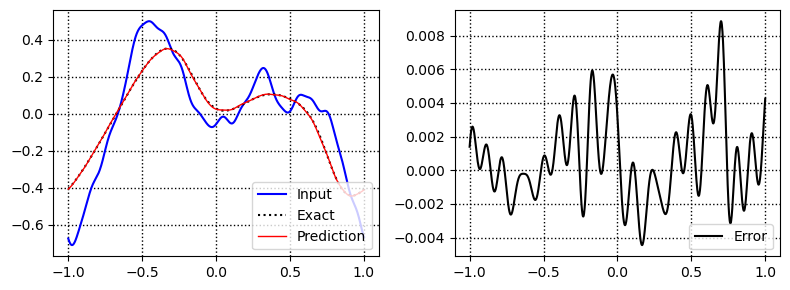

In [18]:
model.eval()
with torch.no_grad():
    x_test, c_test = x_test.to(device), c_test.to(device)
    y_pred = model(x_test, c_test)

x_test_np = x_test.cpu().detach().numpy()
c_test_np = c_test.cpu().detach().numpy()
y_test_np = y_test.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()
print(x_test_np.shape, c_test_np.shape, y_test_np.shape, y_pred_np.shape)

idx = 3
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="lower right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()